# 傅里叶变换是一个神经网络
# The Fourier transform is a neural network

参考链接：  
[1] [微信-你还弄不懂的傅里叶变换，神经网络只用了30多行代码就学会了](https://mp.weixin.qq.com/s/R9yP_-4cR01b2Oi6UNgPpA)  
[2] [网页-The Fourier transform is a neural network](https://sidsite.com/posts/fourier-nets/#amplitude-and-phase-reconstruction-nonlinearities)  
我们可以考虑离散傅里叶变换(discrete Fourier transform，DFT)为一个单层的人工神经网络，没有偏置(bias)，没有激活函数(activation function)，但有特定的权重值。输出节点的数量等于我们评估频率的数量。DFT的公式如下：
$$y_k=\sum_{n=0}^{N-1}x_n \cdot exp(-i \frac{2\pi k}{N}n)\tag{1}$$

- **k**表示每N个样本的循环次数；
- **N**表示信号的长度；
- $x_n$表示信号在样本$n$处的值

一个信号可以表示为所有正弦信号的和。$y_k$是一个复值，它给出了信号$x$中频率为$k$的正弦信号的信息；从$y_k$我们可以计算正弦的振幅和相位。以矩阵式表示如下：

<img src="傅里叶变换.assets/2.DFT公式的矩阵式表示形式.png" alt="DFT公式的矩阵式表示形式" style="zoom:20%;" align="middle"/>

上述公式是特定值$k$的傅里叶值。通常要计算全频谱，即$k$从$[0,1,...,N-1]$的值，用矩阵形式表示($k$按列递增，$n$按行递增)：

<img src="傅里叶变换.assets/3.DFT公式的矩阵式表示形式-2.png" alt="3.DFT公式的矩阵式表示形式" style="zoom: 67%;" />

简化表示如下，这个形式就是一个没有bias和激活函数的神经网络层，其中指数矩阵包含权值，可以称之为**仿复合傅里叶权值(Complex Fourier weights)**，通常情况下我们并不知道神经网络中的权重：

$$y=xW_{ComplexFourier} $$

**替换复数**

神经网络中通常不使用复数，因此需要进行替换。即$e^{i\theta}=cos(\theta)-isin(\theta)$，将$\theta=\frac{2\pi k}{N}n$代入DFT中，可得：$$exp(-i \frac{2\pi k} {N}n)=cos(\frac{2\pi k} {N}n)-isin(\frac{2\pi k} {N}n)$$

然后将原矩阵扩充，使用cos形式表示实部，置于矩阵的左半部分，用sin形式表示虚部，置于矩阵的右半部分：

![4.DFT公式的神经网络表示形式](傅里叶变换.assets/4.DFT公式的神经网络表示形式.png)

公式可简化表示为：$$\hat y=xW_{Fourier}$$，其中$W_{Fourier}$称为**傅里叶权重**。

> $\hat y$和$y$实际上包含相同的信息，但是$\hat y$不适用复数形式，因此长度是$y$的两倍。
>
> 换句话说，我们可以用$W_{Fourier}$或$$W_{ComplexFourier}$$表示振幅和相位，但是通常会使用$W_{Fourier}$

**用傅里叶权重计算傅里叶变换**

用神经网络来实现$\hat y=xW_{Fourier}$，并用快速傅里叶变换(FFT)检查有效性。

In [2]:
from tqdm import tqdm
import numpy as np

def create_fourier_weights(signal_length):  
    "Create weights, as described above."
    k_vals, n_vals = np.mgrid[0:signal_length, 0:signal_length]
    theta_vals = 2 * np.pi * k_vals * n_vals / signal_length
    return np.hstack([np.cos(theta_vals), -np.sin(theta_vals)])

# Generate data:
signal_length = 64
x = np.random.random(size=[1, signal_length]) - 0.5

# Compute Fourier transform using method described above:
W_fourier = create_fourier_weights(signal_length)
y = np.matmul(x, W_fourier)

# Compute Fourier transform using the fast Fourier transform: 
fft = np.fft.fft(x)
y_fft = np.hstack([fft.real, fft.imag])

# Compare the results:
print('rmse: ', np.sqrt(np.mean((y - y_fft)**2)))

rmse:  2.0182105478098648e-14


rmse: 2.760423802248297e-15


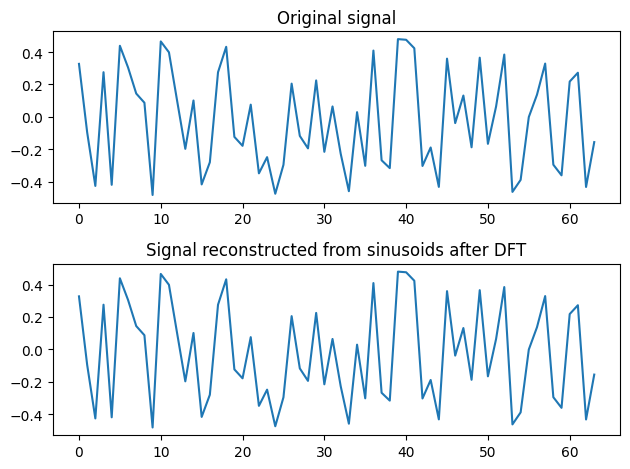

In [3]:
import matplotlib.pyplot as plt

y_real = y[:, :signal_length]
y_imag = y[:, signal_length:]
tvals = np.arange(signal_length).reshape([-1, 1])
freqs = np.arange(signal_length).reshape([1, -1])
arg_vals = 2 * np.pi * tvals * freqs / signal_length
sinusoids = (y_real * np.cos(arg_vals) - y_imag * np.sin(arg_vals)) / signal_length
reconstructed_signal = np.sum(sinusoids, axis=1)

print('rmse:', np.sqrt(np.mean((x - reconstructed_signal)**2)))
plt.subplot(2, 1, 1)
plt.plot(x[0,:])
plt.title('Original signal')
plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal)
plt.title('Signal reconstructed from sinusoids after DFT')
plt.tight_layout()
plt.show()

## 从梯度下降来学习傅里叶变换
learning the Fourier transform via gradient-descent

In [18]:
# -*- coding: utf-8 -*-
# @Time    : 2022/12/29 15:47
# @Author  : Dreamstar
# @File    : 3.learn_fourier_transform_via_gradient_descent.py
# @Desc    : 使用快速傅里叶变换FFT来训练一个神经网络来执行离散傅里叶变换DFT

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


def create_fourier_weights(signal_length):
    "Create weights, as described above."
    k_vals, n_vals = np.mgrid[0:signal_length, 0:signal_length]
    theta_vals = 2 * np.pi * k_vals * n_vals / signal_length
    return np.hstack([np.cos(theta_vals), -np.sin(theta_vals)])


import tensorflow as tf

signal_length = 32

# Initialise weight vector to train:
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)

# Expected weights, for comparison:
W_expected = create_fourier_weights(signal_length)

losses = []
rmses = []

for i in tqdm(range(1000)):
    # Generate a random signal each iteration:
    x = np.random.random([1, signal_length]) - 0.5

    # Compute the expected result using the FFT:
    fft = np.fft.fft(x)
    y_true = np.hstack([fft.real, fft.imag])

    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        loss = tf.reduce_sum(tf.square(y_pred - y_true))

    # Train weights, via gradient descent:
    W_gradient = tape.gradient(loss, W_learned)
    W_learned = tf.Variable(W_learned - 0.1 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected) ** 2)))

loss = np.average(losses)
rmse = np.average(rmses)
print(f'Final loss value:{loss}')
print(f"Final weights' rmse value:{rmse}")

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 593.41it/s]

Final loss value:4.105579559237755
Final weights' rmse value:0.062438434819039886


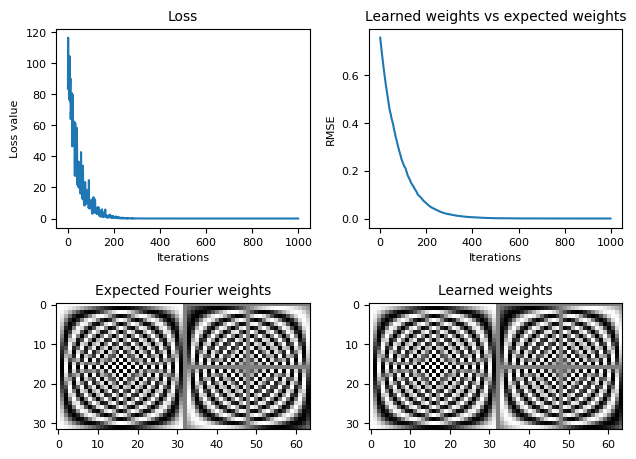

In [26]:
plt.rcParams.update({'font.size':8})  # 全局设置
plt.subplot(2, 2, 1)
plt.plot(losses)
plt.title('Loss', fontsize=10)
plt.xlabel('Iterations', fontsize=8)
plt.ylabel('Loss value', fontsize=8)
plt.xticks(fontsize=8)  # 设置标签
plt.yticks(fontsize=8)
plt.subplot(2, 2, 2)
plt.plot(rmses)
plt.title('Learned weights vs expected weights', fontsize=10)
plt.xlabel('Iterations', fontsize=8)
plt.ylabel('RMSE', fontsize=8)
plt.subplot(2, 2, 3)
plt.imshow(W_expected, vmin=-1, vmax=1, cmap='gray')
plt.title('Expected Fourier weights', fontsize=10)
plt.subplot(2, 2, 4)
plt.imshow(W_learned, vmin=-1, vmax=1, cmap='gray')
plt.title('Learned weights', fontsize=10)
plt.tight_layout()
plt.show()

## 通过重构学习傅里叶变换
learning the Fourier transform via reconstruction

In [31]:
from tqdm import tqdm
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)

tvals = np.arange(signal_length).reshape([-1, 1])
freqs = np.arange(signal_length).reshape([1, -1])
arg_vals = 2 * np.pi * tvals * freqs / signal_length
cos_vals = tf.cos(arg_vals) / signal_length
sin_vals = tf.sin(arg_vals) / signal_length

losses = []
rmses = []

for i in tqdm(range(10000)):
    x = np.random.random([1, signal_length]) - 0.5
    
    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        y_real = y_pred[:, 0:signal_length]
        y_imag = y_pred[:, signal_length:]
        sinusoids = y_real * cos_vals - y_imag * sin_vals
        reconstructed_signal = tf.reduce_sum(sinusoids, axis=1)
        loss = tf.reduce_sum(tf.square(x - reconstructed_signal))

    W_gradient = tape.gradient(loss, W_learned)    
    W_learned = tf.Variable(W_learned - 0.5 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected)**2)))
loss = np.average(losses)
rmse = np.average(rmses)
print(f'Final loss value:{loss}')
print(f"Final weights' rmse value:{rmse}")

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 241.30it/s]

Final loss value:0.05881874172861317
Final weights' rmse value:0.21067086212332414


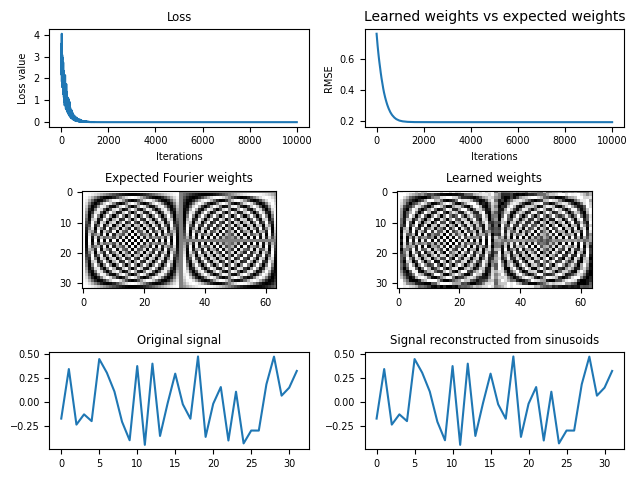

In [36]:
plt.rcParams.update({'font.size': 7})  # 全局设置
plt.subplot(3, 2, 1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss value')
# plt.xticks(fontsize=8)  # 设置标签
# plt.yticks(fontsize=8)
plt.subplot(3, 2, 2)
plt.plot(rmses)
plt.title('Learned weights vs expected weights', fontsize=10)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.subplot(3, 2, 3)
plt.imshow(W_expected, vmin=-1, vmax=1, cmap='gray')
plt.title('Expected Fourier weights')
plt.subplot(3, 2, 4)
plt.imshow(W_learned, vmin=-1, vmax=1, cmap='gray')
plt.title('Learned weights')
plt.subplot(3, 2, 5)
plt.plot(x[0,:])
plt.title('Original signal')
plt.subplot(3, 2, 6)
plt.plot(reconstructed_signal)
plt.title('Signal reconstructed from sinusoids')
plt.tight_layout()
plt.show()

## 振幅和相位重构(非线性)
Amplitude and phase reconstruction (nonlinearities)

In [40]:
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)

losses = []
rmses = []

for i in tqdm(range(10000)):
    x = np.random.random([1, signal_length]) - .5
    
    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        y_real = y_pred[:, 0:signal_length]
        y_imag = y_pred[:, signal_length:]
        amplitudes = tf.sqrt(y_real**2 + y_imag**2) / signal_length
        phases = tf.atan2(y_imag, y_real)
        sinusoids = amplitudes * tf.cos(arg_vals + phases)
        reconstructed_signal = tf.reduce_sum(sinusoids, axis=1)
        loss = tf.reduce_sum(tf.square(x - reconstructed_signal))

    W_gradient = tape.gradient(loss, W_learned)
    W_learned = tf.Variable(W_learned - 0.5 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected)**2)))
    
loss = np.average(losses)
rmse = np.average(rmses)
print(f'Final loss value:{loss}')
print(f"Final weights' rmse value:{rmse}")

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:00<00:00, 165.96it/s]


Final loss value:0.05818913527618594
Final weights' rmse value:0.22252843817803747


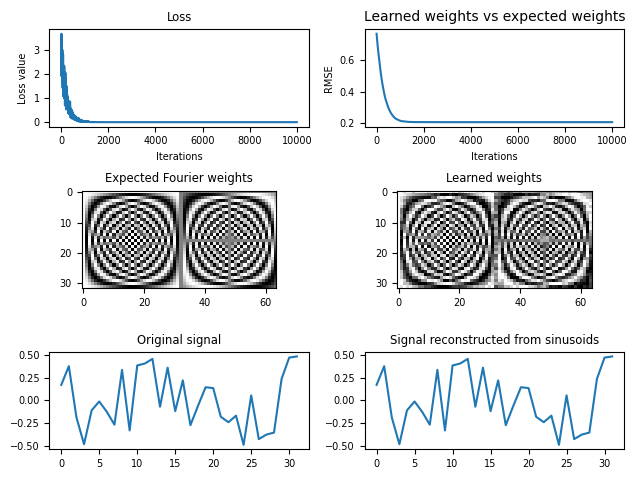

In [41]:
plt.rcParams.update({'font.size': 7})  # 全局设置
plt.subplot(3, 2, 1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss value')
# plt.xticks(fontsize=8)  # 设置标签
# plt.yticks(fontsize=8)
plt.subplot(3, 2, 2)
plt.plot(rmses)
plt.title('Learned weights vs expected weights', fontsize=10)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.subplot(3, 2, 3)
plt.imshow(W_expected, vmin=-1, vmax=1, cmap='gray')
plt.title('Expected Fourier weights')
plt.subplot(3, 2, 4)
plt.imshow(W_learned, vmin=-1, vmax=1, cmap='gray')
plt.title('Learned weights')
plt.subplot(3, 2, 5)
plt.plot(x[0,:])
plt.title('Original signal')
plt.subplot(3, 2, 6)
plt.plot(reconstructed_signal)
plt.title('Signal reconstructed from sinusoids')
plt.tight_layout()
plt.show()

Epoch 1/100
100/100 [==============================] - 0s 832us/step - loss: 29.8303
Epoch 2/100
100/100 [==============================] - 0s 846us/step - loss: 24.3734
Epoch 3/100
100/100 [==============================] - 0s 907us/step - loss: 19.7406
Epoch 4/100
100/100 [==============================] - 0s 876us/step - loss: 15.8395
Epoch 5/100
100/100 [==============================] - 0s 796us/step - loss: 12.5830
Epoch 6/100
100/100 [==============================] - 0s 846us/step - loss: 9.8906
Epoch 7/100
100/100 [==============================] - 0s 856us/step - loss: 7.6872
Epoch 8/100
100/100 [==============================] - 0s 766us/step - loss: 5.9036
Epoch 9/100
100/100 [==============================] - 0s 766us/step - loss: 4.4769
Epoch 10/100
100/100 [==============================] - 0s 836us/step - loss: 3.3501
Epoch 11/100
100/100 [==============================] - 0s 907us/step - loss: 2.4717
Epoch 12/100
100/100 [==============================] - 0s 821us/step

100/100 [==============================] - 0s 766us/step - loss: 1.6085e-12
Epoch 95/100
100/100 [==============================] - 0s 776us/step - loss: 1.4954e-12
Epoch 96/100
100/100 [==============================] - 0s 756us/step - loss: 1.3943e-12
Epoch 97/100
100/100 [==============================] - 0s 756us/step - loss: 1.3008e-12
Epoch 98/100
100/100 [==============================] - 0s 766us/step - loss: 1.2127e-12
Epoch 99/100
100/100 [==============================] - 0s 761us/step - loss: 1.1464e-12
Epoch 100/100
1/1 [==============================] - 0s 52ms/step
ANN matches FFT: True


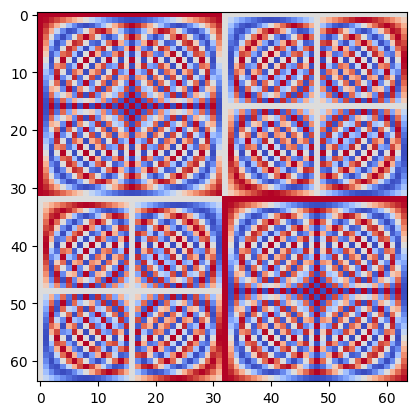

In [10]:
"""
Train a neural network to implement the discrete Fourier transform
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

N = 32
batch = 10000

# Generate random input data and desired output data
sig = np.random.randn(batch, N) + 1j*np.random.randn(batch, N)
F = np.fft.fft(sig, axis=-1)

# First half of inputs/outputs is real part, second half is imaginary part
X = np.hstack([sig.real, sig.imag])
Y = np.hstack([F.real, F.imag])

# Create model with no hidden layers, same number of outputs as inputs.
# No bias needed.  No activation function, since DFT is linear.
model = Sequential([Dense(N*2, input_dim=N*2, use_bias=False)])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=100)

# Confirm that it works
data = np.arange(N)


def ANN_DFT(x):
    if len(x) != N:
        raise ValueError(f'Input must be length {N}')
    pred = model.predict(np.hstack([x.real, x.imag])[np.newaxis])[0]
    result = pred[:N] + 1j*pred[N:]
    return result


ANN = ANN_DFT(data)
FFT = np.fft.fft(data)
print(f'ANN matches FFT: {np.allclose(ANN, FFT)}')

# Heat map of neuron weights
plt.imshow(model.get_weights()[0], vmin=-1, vmax=1, cmap='coolwarm')